In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.set_palette("muted")

import patsy
import lifelines

# A Crash Course in Survival Analysis: Analyzing Customer Churn

## Introduction

Customer churn is familiar to many companies offering subscriptions services. Simply put, customer churn is the event of a customer opting out of his subscription. They may do so for different reasons: dissatisfaction of their mobile plan because of consistently poor reception, the allure of better subscription packages from competitors, or other reasons.

Businesses want to understand how and why their customers churn to improve their profits. In this blog post, we'll explore a branch of statistics called *survival analysis* to uncover insights that will be useful to curb churn. We'll use a churn dataset from a [blog from IBM Watson analytics community](https://www.ibm.com/communities/analytics/watson-analytics-blog/predictive-insights-in-the-telco-customer-churn-data-set/) that describes a fictitious telco's customers and how long they stayed before they churned. 

## Survival Analysis

Survival analysis has been traditionally used in medicine in the life sciences to analyze how long it takes before a person dies  - hence the "survival" in survival analysis. The field however can be used to model other events that organizations care about, such as the failure of a machine, or customer churn. Okay cool. But what are the kinds of insights we can get from survival analysis? 

We'll talk about two main ideas: survival curves, and survival regression. We'll discuss what they are, and what kinds of insights they bring to the table.

1. Survival Curves
<img src = "images/survival_curve.gif">
    - What we can do with it: 
        - Show how the likelihood of customer churn changes **over time**.
        - Determining optimal intervention point.
    - Questions it can answer:
        - How many years/months on average do our customers stay?
        - How long do male customers stay compared to female customers?
        - Is our understanding of our customer lifecycle accurate with reality?
2. Survival Regression
    - What we can do with it: 
        - Model the relationship between customer churn, time, and other customer characteristics.
    - Questions it can answer:
        - What's the probability that this customer who is a female non-senior citizen with dependents will stay for 2 years?
        - What are the significant factors that drive churn?
        
Survival analysis can be applied to industries other than telco [(source)](http://www.barryanalytics.com/Downloads/Presentations/Survival%20Analysis.pdf):
> 
- Insurance - time to lapsing on policy.
- Mortgages - time to mortgage redemption
- Mail Order Catalogue - time to next purchase
- Retail - time till food customer starts purchasing non-food
- Manufacturing - lifetime of a machine component
- Public Sector - time intervals to critical events

## The Dataset

Let's get started by examining our sample churn dataset from IBM. Our dataset has 7043 customers and 21 variables. Most of the variables are categorical. 

In [2]:
df = pd.read_csv("data/Telco-Customer-Churn.csv")
df.replace(r"^\s+", np.nan, inplace = True, regex = True)
df["TotalCharges"] = df.TotalCharges.apply(lambda x: float(x))

In [3]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ...   DeviceProtection  \
0  No phone service             DSL             No  ...                 No   
1                No             DSL            Yes  ...                Yes   
2                No             DSL            Yes  ...                 No   
3  No phone service             DSL            Yes  ...                Yes   
4                No     Fiber optic             No  ...                 No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn  
0           Electronic check          29.85         29.85     No  
1               Mailed check          56.95       1889.50     No  
2               Mailed check          53.85        108.15    Yes  
3  Bank transfer (automatic)          42.30       1840.75     No  
4           Electronic check          70.70        151.65    Yes  

[5 rows x 21 columns]

In [4]:
# printing out all the unique values the variables take to get some perspective of what we're dealing with
for column in df.columns:
    print(column, df[column].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ..., '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27  5
 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68 32 55
 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0 39]
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (a

Here's a simple exploratory plot - a histogram. We can see how monthly charges are distributed across customers. A large proportion of customers are paying around $20 per month.

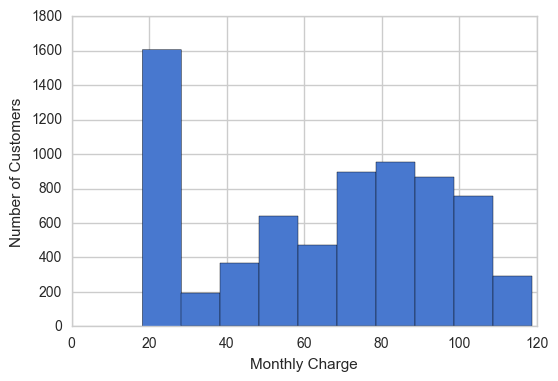

In [7]:
plt.hist(df.MonthlyCharges.values)
plt.xlabel("Monthly Charge")
plt.ylabel("Number of Customers")
plt.show()

Let's do some data cleaning before we draw our survival curves.

In [5]:
# converting binary variables to "Yes" and "No" from 1 and 0 to be consistent
df.loc[:,"Churn"] = df.Churn.apply(lambda x: 1 if x == "Yes" else 0)
df.loc[:,"SeniorCitizen"] = df.SeniorCitizen.apply(lambda x: "Yes" if x == 1 else "No")

In [7]:
# remove the customer who just started
df = df[df.tenure != 0]

## Survival Curves

The survival curve is fundamental in survival analysis. It tells us the probability that a customer will still be subscribed to the company. The longer the time, the smaller the probability of *surviving*.  

One way of estimating the survival curve is through using the Weibull distribution. The Weibull distribution is a natural choice for modelling time-to-death data. Using this, we can sketch the survival curve of a typical customer in our dataset.

In [10]:
# defining a function that plots a Weibull survival curve since there isn't one in lifelines
def plot_surv_weibull(weibull_model, ax, max_time = 150):
    max_time = np.floor(max_time).astype(int)
    x = np.array(range(max_time))
    y = np.exp(-(weibull_model.lambda_*x)**weibull_model.rho_)
    ax.plot(x,y, label = weibull_model._label)
    plt.legend()

C:\Users\jmercado\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


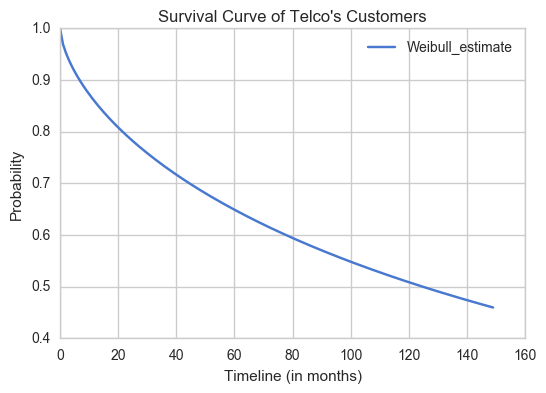

In [11]:
weib = lifelines.WeibullFitter()
weib.fit(durations = df.tenure, event_observed = df.Churn)
ax = plt.subplot(111)
plot_surv_weibull(weib, ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability")
plt.show()

Here's our survival curve. It isn't steep. For instance, there's around a 50% chance that a customer longer than 120 months (almost 10 years). It is also important to check if this checks in with the business' understanding of their customer lifecycle. If their customers are churning much earlier/later than the business perceives them to be, then the business may have to tweak its customer lifecycle management.

It also may be a good idea to intervene and incentivize customers who have already stayed for 10 years. Since their probability of staying is dipping below 50%, then without intervention, they are more likely to churn than not to churn.  

## Comparing Survival Curves

We can also compare survival curves of customer segments. For example, do females and males churn differently? 

We can first look at total counts. How many females have churned versus males?

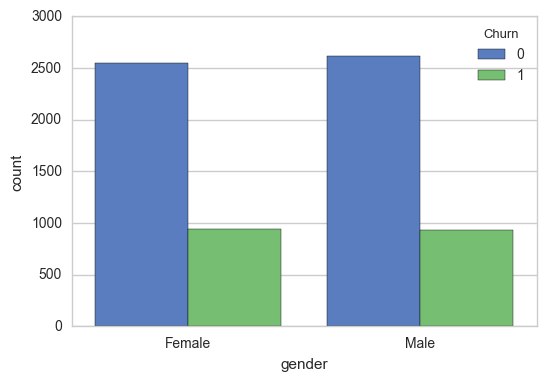

In [19]:
sns.countplot(x = "gender", hue = "Churn", data = df)
plt.show()

It looks like males and females churn in similar proportions. We expect the survival curves to also be almost the same.

C:\Users\jmercado\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


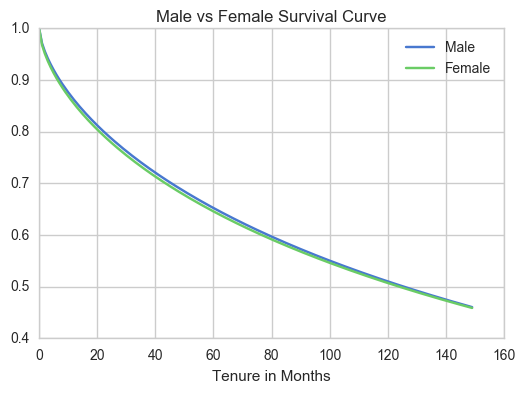

In [20]:
is_male = (df.gender == "Male")

weib_male = lifelines.WeibullFitter()
weib_female = lifelines.WeibullFitter()

ax = plt.subplot(111)

weib_male.fit(durations = df.tenure[is_male], event_observed = df.Churn[is_male], label = "Male")
plot_surv_weibull(weib_male, ax)
weib_female.fit(durations = df.tenure[~is_male], event_observed = df.Churn[~is_male], label = "Female")
plot_surv_weibull(weib_female, ax)

plt.title("Male vs Female Survival Curve")
plt.xlabel("Tenure in Months")
plt.show()

The survival curves are indeed the same, and furthermore they look identical to the survival group of the whole population. This means we can expect males and females to last around 9.2 years with the telco.

C:\Users\jmercado\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\jmercado\Anaconda3\lib\site-packages\lifelines\fitters\weibull_fitter.py:117: RuntimeWarning: divide by zero encountered in power
  return self.lambda_ * self.rho_ * (self.lambda_ * times) ** (self.rho_ - 1)
C:\Users\jmercado\Anaconda3\lib\site-packages\lifelines\fitters\weibull_fitter.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(lambda_ * T) * (lambda_ * T) ** rho
C:\Users\jmercado\Anaconda3\lib\site-packages\lifelines\fitters\weibull_fitter.py:173: RuntimeWarning: invalid value encountered in multiply
  return np.log(lambda_ * T) * (lambda_ * T) ** rho


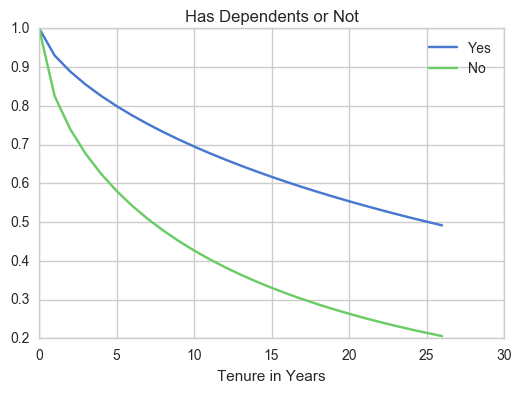

In [21]:
has_dependents = (df.Dependents == "Yes")

weib_has_dependents = lifelines.WeibullFitter()
weib_no_dependents = lifelines.WeibullFitter()

ax = plt.subplot(111)
max_time = 325/12
weib_has_dependents.fit(durations = df.tenure[has_dependents]/12, event_observed = df.Churn[has_dependents], label = "Yes")
plot_surv_weibull(weib_has_dependents, ax, max_time)
weib_no_dependents.fit(durations = df.tenure[~has_dependents]/12, event_observed = df.Churn[~has_dependents], label = "No")
plot_surv_weibull(weib_no_dependents, ax, max_time)

plt.title("Has Dependents or Not")
plt.xlabel("Tenure in Years")
plt.show()

Those without dependents are going to last around 7.5 years. On the other hand, those with dependents last significantly longer, around 25 years. Performing a log-rank test will confirm that these survival curves are indeed different from each other. The result of the test (given alpha = 0.95) should be a rejection of the null hypothesis.

In [22]:
from lifelines.statistics import logrank_test
logrank_test(event_times_A = df.tenure[has_dependents].values,
             event_times_B = df.tenure[~has_dependents].values,
             event_observed_A = df.Churn[has_dependents].values,
             event_observed_B = df.Churn[~has_dependents].values)

C:\Users\jmercado\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:224: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


<lifelines.StatisticalResult: 
Results
   t 0: -1
   df: 1
   alpha: 0.95
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |            232.699 |      Reject Null    |        True       
>

## Survival Regression

Knowing how long customers stay is all well and good, but what if we want to know the factors that influence churn? What if we want to predict how long a given customer will churn? Survival regression can do that for us.

Here we'll specifically focus on **Cox regression**, which uses Cox's Proportional Hazard Model to perform survival regression. The main insight the Cox regression model gives us are its coefficients. The (exponential of the) coefficients correspond to the hazard ratios. What does the hazard ratio mean? *It is a relative measure of the instantaneous rate of failure*. Don't worry if that sounds confusing, it's better to consider an example.  

For example, let's say we've fitted a Cox regression model, and one of the variables is `gender`. This variable takes on two values: 1 for male, and 0 for female. What does it mean if hazard ratio of `gender` is 1.10? It means that *at any time*, whether it's 6 months since signing up or 12 months since signing up, males are 10% more likely to churn versus females.

The hazard ratio is a relative measure, not an absolute measure. So it should be understood as how females fare in relation to males (or vice versa).  

Unfortunately the `lifelines` package in Python can't fit a Cox regression model using our data, so I did it in R instead.

---
Note: `lifelines` kept on complaining that the matrix it was handling was singular.

In [23]:
keep_cols = ["tenure", "Churn", "PaperlessBilling", "SeniorCitizen", "Dependents", "gender"]
df_clean = df.loc[:,keep_cols]
df_mat = patsy.dmatrix(" + ".join(df_clean.columns.tolist()) ,df_clean, return_type = "dataframe")

In [24]:
coxph = lifelines.CoxPHFitter()
try:
    coxph.fit(df_mat, duration_col = "tenure", event_col = "Churn", show_progress = True)
    coxph.print_summary()
except:
    print("Can't fit the model using lifelines.")

Can't fit the model using lifelines.


Now instead let's fit a Cox regression model with variable stratification.

In [25]:
keep_cols = ["tenure", "Churn", "PaperlessBilling", "SeniorCitizen", "Dependents", "gender", "PaymentMethod", "Partner", "InternetService", "PhoneService", "Contract"]
strata = ["PaymentMethod", "Partner", "InternetService", "PhoneService", "Contract"]
df_clean = df.loc[:,keep_cols]
df_mat = patsy.dmatrix(" + ".join(df_clean.columns.tolist()) + " - 1" ,df_clean, return_type = "dataframe")

In [26]:
strata_mat = []
for col_long in df_mat.columns.tolist():
    for col_short in strata:
        if col_short in col_long:
            strata_mat.append(col_long)
            continue
coxph = lifelines.CoxPHFitter()
try: 
    coxph.fit(df_mat, duration_col = "tenure", event_col = "Churn", strata = strata_mat, show_progress = True)
    coxph.print_summary()
except:
    print("Still can't fit the CPX model using lifelines.")


Still can't fit the CPX model using lifelines.


## Proportional hazards assumption

Cox regression has a very important assumption, the **proportional hazards assumption**. The variables in this model should first be tested on whether or not they follow this assumption.

It means that the **hazard ratio** of all variables should be constant over time. For example, we have the variable "dependents" that is 1 if the customer has dependents (e.g. children) and 0 if he/she doesn't have dependents. If the proportional hazards assumption holds, then, **at any time**, those with dependents are 30% more likely to churn than those without dependents. It **doesn't** happen that for the first month up to the third month, those with dependents are 30% more likely, then from the third month to the sixth month, it changes to 15%. The hazard ratio should be more or less the same **across time**.

<img src = "images/prop_hazard_assumption.jpg">

It's possible to test this assumption using a statistical test in R. 

---
Note: It may be easy to confuse the hazard ratio with the odds ratio (seen in logistic regression). Both measure the chances of an outcome (e.g. death) occurring for category (male) versus the outcome occurring for another category (female). The main difference is that the hazard ratio incorporates an element of time, while the odds ratio has no concept of time. More specifically, the hazard ratio is the ratio of instantaneous risk.  

We found that only the following variables satisfy the proportional hazards assumption: `PaperlessBilling`, `SeniorCitizen`, `Dependents`, and `gender`. Let's now use these variables to fit a model. 

---
Note: It's unfortunate that we'll have to leave out the other variables, but there are other methods (stratified cox regression, cox regression with time-dependent covariates, pseudo-observations) that can incorporate variables that *don't* follow the proportional hazards assumption.  

### R's Cox regression results

After filtering the variables, we can (finally) fit a model and interpret its results.

`
Call:
coxph(formula = survival ~ gender + SeniorCitizen + Dependents + 
    PaperlessBilling, data = df)

  n= 7043, number of events= 1869 
`

`
                        coef exp(coef) se(coef)       z Pr(>|z|)    
genderMale          -0.02079   0.97942  0.04627  -0.449    0.653    
SeniorCitizen        0.26499   1.30342  0.05457   4.856  1.2e-06 ***
DependentsYes       -0.78207   0.45746  0.06233 -12.547  < 2e-16 ***
PaperlessBillingYes  0.61206   1.84423  0.05399  11.336  < 2e-16 ***
`

`
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
`

`
                    exp(coef) exp(-coef) lower .95 upper .95
genderMale             0.9794     1.0210    0.8945    1.0724
SeniorCitizen          1.3034     0.7672    1.1712    1.4505
DependentsYes          0.4575     2.1860    0.4048    0.5169
PaperlessBillingYes    1.8442     0.5422    1.6590    2.0501
`

`
Concordance= 0.628  (se = 0.007 )
Rsquare= 0.061   (max possible= 0.988 )
Likelihood ratio test= 441.4  on 4 df,   p=0
Wald test            = 386.5  on 4 df,   p=0
Score (logrank) test = 411.2  on 4 df,   p=0
`

Here's what the cox regression model (finally) tells us:
- Gender isn't a good indicator of churn. This confirms what we saw earlier when we compared the survival curves between female and male customers. They're equally likely to churn.
- Senior citizenship, having dependents, and having paperless billing **are indicative** of churn. We can also quantify their effects.
    1. Senior citizens are **30% more likely** to churn than non-senior citizens
    2. Customers without dependents are **twice as likely** to churn more than those with dependents. This also validates the survival curves earlier. The difference is that now, we have a number to compare both groups.
    3. Customers with paperless billing are **1.8 times more likely** to churn than those without paperless billing.

# Taking these insights to action

We saw three significant factors to churn. We can leave out the Senior citizen factor and that leaves us with two. Senior citizens might be more at risk of churning not because they're willingly opting out of the subscription service, but because they're passing away. Furthermore, the hazard ratio of the senior citizen factor is lower (30%) compared to the other two anyway.

The paperless billing factor is surprising since you'd expect customers to prefer the convenience and speed of receiving their bills online. There are various possibilities as to why this is happening. However, the business should investigate if their paperless billing processes are properly implemented. Also, majority of the customers are under paperless billing so this is an important issue.  

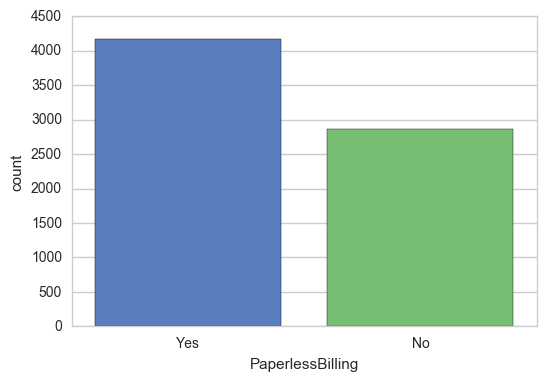

In [17]:
sns.countplot(x = "PaperlessBilling", data = df)
plt.show()

We see from the graph below that there are more than twice as many customers **without dependents** than with dependents. At the same time, those without dependents are **twice as likely** to churn. This means that there should be more efforts to retain this segment of customers.

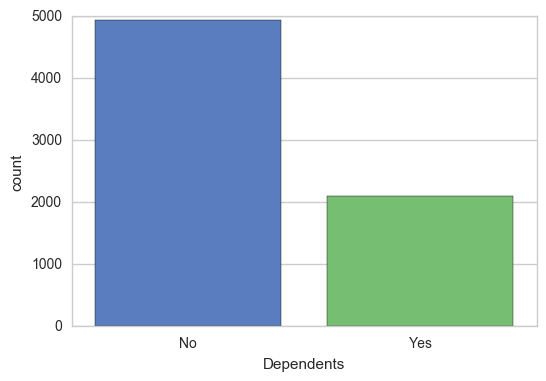

In [16]:
sns.countplot(x = "Dependents", data = df)
plt.show()

These are just some of the ways that survival analysis can be used to address business problems. [Barry Leventhal](http://www.barryanalytics.com/Downloads/Presentations/Survival%20Analysis.pdf) has recommended other use cases:
> 
- Business Planning
    - Forecast monthly number of lapses and use to monitor current lapse rates.
- Lifetime Value (LTV) prediction
    - Derive LTV predictions by combining expected survival times with monthly revenues.
- Active customers
    - Predict each customer's time to next purchase, and use to identify "active" vs. "inactive" customers.
- Campaign evaluation
    - Monitor effects of campaigns on survival rates.
    
With that, I hope this branch of statistics can be useful to a problem that you're solving.

## Resource materials

The following resources were extremely helpful in making this post. Check them out if you want to learn more about survival analysis.

- [Customer Churn Dataset](https://www.ibm.com/communities/analytics/watson-analytics-blog/predictive-insights-in-the-telco-customer-churn-data-set/)
- [Dayne Batten's blog posts on survival analysis in the business setting](http://daynebatten.com/category/survival-analysis/)
- Here's a good resource on [stratified cox regression](https://stat.ethz.ch/education/semesters/ss2011/seminar/contents/presentation_5.pdf), and this [course on survival analysis](https://stat.ethz.ch/education/semesters/ss2011/seminar/) in general has great content.
- [Barry Leventhal's presentation with business insights](http://www.barryanalytics.com/Downloads/Presentations/Survival%20Analysis.pdf)
- [The Survival Package in R](https://cran.r-project.org/web/packages/survival/survival.pdf)
- [The Lifelines Package in Python](https://lifelines.readthedocs.io/en/latest/)